# Tutorial: Training, Masked Word Prediction, Language Modeling, Importance of Positions

In this tutorial, we are going to train our *position-independent word embeddings* and compare it with the word embeddings of the subword model (fastText) of [Bojanowski et al. (2017)][1] and the positional model of [Mikolov et al. (2018)][2] on a number of natural language processing tasks.

 [1]: https://www.aclweb.org/anthology/Q17-1010.pdf
 [2]: https://www.aclweb.org/anthology/L18-1008.pdf

## Word Embeddings

Recent deep neural language models based on the Transformer architecture are Turing-complete universal approximators that can understand language better than humans on a number of natural language processing tasks.

In contrast, log-bilinear language models such as word2vec, fastText, and GLoVE are shallow and use a simplifying bag-of-words representation of text, which severely limits their predictive ability. However, they are fast and cheap to train on large corpora and their internal *word embeddings* can be used for transfer-learning to improve the performance of other models.

## Position-Independent Word Embeddings

Our constrained positional model improves the bag-of-words representation of text by allowing the model to react to the position of words in a sentence and produce *position-independent word embeddings* without sacrificing the simplicity and speed that is pivotal to the success of log-bilinear language models. Unlike the positional model of [Mikolov et al. (2018)][2], our model *constrains* the capacity dedicated to modeling the positions of words, which improves the speed of the model as well as its accuracy on a number of natural language processing tasks.

## Python Package

You can find our package [here][3].

[![Continuous Integration Status](https://github.com/MIR-MU/pine/workflows/Test/badge.svg)](https://github.com/MIR-MU/pine/actions?query=workflow%3ATest)
[![Documentation Status](https://readthedocs.org/projects/position-independent-embeddings/badge/?version=latest)](https://readthedocs.org/projects/position-independent-embeddings/?badge=latest)

 [3]: https://github.com/MIR-MU/pine


# Installing Position-Independent Word Embeddings

First, we will install our position-independent word embeddings library.

In [1]:
%%capture
! pip install -U pip
! pip install git+https://github.com/MIR-MU/pine.git
! pip install -U gdown

## Restart the Notebook

For the changes to take effect, we now need to restart the notebook.

From the Menu:

Runtime → Restart Runtime

# Downloading the Workspace Data

For convenience, we will download a workspace with pre-trained language models (20 GiB), so that we don't have to wait for their training to finish. If you would like to reproduce our results, you can skip this step.

In [2]:
from gdown.cached_download import cached_download as download

In [ ]:
download('https://drive.google.com/uc?id=1jgYM4HP-y7BBshf8ntTk4oAYXTWf929O', 'pine-workspace.zip')

In [4]:
%%capture
! unzip -n pine-workspace.zip

# Training the Language Models

In this section of our tutorial, we are going to introduce and train a number of different shallow log-bilinear language models of the English Wikipedia corpus (15 GiB). In the following sections, we will compare these models on a number of quantitative and qualitative tasks!

In [5]:
from pine import LanguageModel

First, we will train the subword model (fastText) of [Bojanowski et al. (2017)][1]. Unlike the earlier word2vec model, fastText uses subwords as well as words during the training. This is known to improve the speed of convergence, especially for inflected natural languages.

 [1]: https://www.aclweb.org/anthology/Q17-1010.pdf

In [6]:
subword_model = LanguageModel(corpus='wikipedia', language='en', positions=False)
subword_model

Language model: wikipedia-en-fasttext_cbow
Word analogy accuracy: 66.39% (en)
Disk size: 9.0 GB (+ 0 Bytes in cache)
Training duration: an hour

You can see that the model is fast and breezes through the entire English Wikipedia in just an hour of training time.

Next, we will train the positional model of [Mikolov et al. (2018)][1]. Unlike word2vec and fastText, the positional model trains not only word embedding and subword embeddings, but also *positional embeddings*. This makes it possible for the model to distinguish between words on different positions in a sentence and produce a better position-independent representations of words.

 [1]: https://www.aclweb.org/anthology/L18-1008.pdf

In [7]:
positional_model = LanguageModel(corpus='wikipedia', language='en', positions='full', use_vocab_from=subword_model)
positional_model

Language model: wikipedia-en-positional_fasttext_cbow
Word analogy accuracy: 74.85% (en)
Disk size: 8.9 GB (+ 0 Bytes in cache)
Training duration: 4 hours

We can see that the positional model is four times slower than fastText. There are several factors that contribute to this slowdown:

 1. Due to its better language modeling capabilities, the positional model is able to make use of a three times larger *context window* (15 instead of 5) during the training. Although this improves the accuracy of the model, it also triples the amount of work at each step of the training.
 2. Unlike the fastText model, which only updates word and subword embeddings at each step of the training, the positional model also updates the positional weights, which doubles the amount of word at each step of the training.

[Novotný (2020)][1] shows that this slowdown makes the positional model impractical, since training the fastText model for four more epochs than the positional model leads to greater accuracy than what the positional model can achieve.

 [1]: https://nlp.fi.muni.cz/raslan/raslan20.pdf#page=63

Finally, we will train our constrained positional model. Unlike the positional model, which uses 300 *dimensions* for word, subword, and positional embeddings, out constrained positional model only uses 60 dimensions for the positional embeddings, which we show leads to greater speed and a better representation of words.

In [8]:
constrained_positional_model = LanguageModel(corpus='wikipedia', language='en', positions='constrained', use_vocab_from=subword_model)
constrained_positional_model

Language model: wikipedia-en-constrained_positional_fasttext_cbow
Word analogy accuracy: 72.26% (en)
Disk size: 8.8 GB (+ 0 Bytes in cache)
Training duration: 2 hours

We can see that our constrained positional model is only twice as slow as fastText. This improvement is due to the smaller dimensionality of the positional embeddings.

In [9]:
language_models = [subword_model, positional_model, constrained_positional_model]

# Masked Word Prediction

We usually only use the word embeddings and throw away the shallow log-bilinear language models. This is because these models are not so great at actual language modeling due to their simplifying bag-of-words representation of text. However, with the addition of positional embeddings, the models should now be much more capable at predictive typing.

In this section, we will take a look at a number of sentences with some words *masked*. We will the investigate what our models predict the masked words should be.

## It's Raining Cats and Dogs!

The first two sentences will test the ability of our models to consider the positions of words:

 1. Unlike cats, dogs *(masked word)*.
 2. Unlike dogs, cats *(masked word)*.

As our candidates for the masked words, we will use the words *mew* and *bark*.

In [10]:
unlike_dogs_cats = ['unlike', 'dogs', 'cats', '[MASK]']
unlike_cats_dogs = ['unlike', 'cats', 'dogs', '[MASK]']

For the fastText model, these two sentences are identical, since the model only sees the bag-of-words representation $\{\text{cats}, \text{dogs}, \text{unlike}\}$:

In [11]:
subword_model.get_masked_word_probability(unlike_dogs_cats, 'mew')

unlike dogs cats [MASKED: mew] (score -0.63, probability 34.83%)

In [12]:
subword_model.get_masked_word_probability(unlike_cats_dogs, 'mew')

unlike cats dogs [MASKED: mew] (score -0.63, probability 34.83%)

In [13]:
subword_model.get_masked_word_probability(unlike_dogs_cats, 'bark')

unlike dogs cats [MASKED: bark] (score 4.84, probability 99.22%)

In [14]:
subword_model.get_masked_word_probability(unlike_cats_dogs, 'bark')

unlike cats dogs [MASKED: bark] (score 4.84, probability 99.22%)

However, the positional model can differentiate between the two sentences.  
For the first sentence, the positional model correctly ranks *mew* above *bark*:

In [15]:
positional_model.get_masked_word_probability(unlike_dogs_cats, 'mew')

unlike dogs cats [MASKED: mew] (score 9.58, probability 99.99%)

In [16]:
positional_model.get_masked_word_probability(unlike_dogs_cats, 'bark')

unlike dogs cats [MASKED: bark] (score 5.70, probability 99.67%)

For the second sentence, the positional model correctly ranks *bark* above *mew*:

In [17]:
positional_model.get_masked_word_probability(unlike_cats_dogs, 'bark')

unlike cats dogs [MASKED: bark] (score 7.22, probability 99.93%)

In [18]:
positional_model.get_masked_word_probability(unlike_cats_dogs, 'mew')

unlike cats dogs [MASKED: mew] (score 6.07, probability 99.77%)

## Fruit Flies Like a Banana, Time Flies Like an Arrow!

The other two sentences will test the ability of our models to distinguish between two sentences, where one is ambiguous and the other is not:

1. Fruit flies like *(masked word)*.
2. *(Masked word)* flies like fruit.

The first sentence has two possible interpretations:

- What the insects like. Here, the sentence parses as adjective-noun-verb-*(noun)*.
- How a fruit can fly. Here, the sentence parses as noun-verb-preposition-*(noun)*.

Some masked words such as *moisture* satisfy only the first interpretation. Others, such as *a vegetable* satisfy both.

The second sentence only admits the second interpretation. The masked words still include *a vegetable*, but no longer *moisture*.

In [19]:
fruit_flies_like = ['fruit', 'flies', 'like', '[MASK]']
flies_like_fruit = ['[MASK]', 'flies', 'like', 'fruit']

For fastText, the two sentences are again identical, since the model only sees the bag-of-words representation $\{\text{like}, \text{flies}, \text{fruit}\}$:

In [20]:
subword_model.get_masked_word_probability(sentence=fruit_flies_like, masked_word='moisture')

fruit flies like [MASKED: moisture] (score 0.47, probability 61.56%)

In [21]:
subword_model.get_masked_word_probability(masked_word='moisture', sentence=flies_like_fruit)

[MASKED: moisture] flies like fruit (score 0.47, probability 61.56%)

In [22]:
subword_model.get_masked_word_probability(sentence=fruit_flies_like, masked_word='vegetable')

fruit flies like [MASKED: vegetable] (score 5.74, probability 99.68%)

In [23]:
subword_model.get_masked_word_probability(masked_word='vegetable', sentence=flies_like_fruit)

[MASKED: vegetable] flies like fruit (score 5.74, probability 99.68%)

However, our constrained positional model can differentiate between the two sentences.  
For the masked word *moisture*, the model correctly ranks it higher for the first sentence than it does for the second sentence:

In [24]:
constrained_positional_model.get_masked_word_probability(sentence=fruit_flies_like, masked_word='moisture')

fruit flies like [MASKED: moisture] (score 0.83, probability 69.58%)

In [25]:
constrained_positional_model.get_masked_word_probability(masked_word='moisture', sentence=flies_like_fruit)

[MASKED: moisture] flies like fruit (score -0.29, probability 42.83%)

For the masked word *vegetable*, the model correctly assigns similar probability in both sentences:

In [26]:
constrained_positional_model.get_masked_word_probability(sentence=fruit_flies_like, masked_word='vegetable')

fruit flies like [MASKED: vegetable] (score 7.19, probability 99.92%)

In [27]:
constrained_positional_model.get_masked_word_probability(masked_word='vegetable', sentence=flies_like_fruit)

[MASKED: vegetable] flies like fruit (score 6.89, probability 99.90%)

# Language Modeling

One of the great strengths of shallow log-bilinear language models it the ability to use transfer-learning with their word embeddings to improve the performance of other models.

In this section, we will train three RNN language models, using the word embeddings of fastText, the positional model, and the constrained positional model to initialize the lookup tables of these RNN language models. This will show us how useful the word embeddings of each model are for transfer learning.

The RNN architecture we will be using for the language models is the following:

1. an input layer mapping a vocabulary of words to their *frozen* word embeddings,
2. two hidden layers with 300 LSTM units,
3. a fully-connected linear layer of size the size of the vocabulary, and
4. a softmax output layer that computes a probability distribution over the vocabulary using tied weights.

We evaluate our language model on [the English datasets][1] introduced by [Botha et al. (2014)][2] and we report the validation and test perplexities. We use the same preprocessing and data splits as Botha et al. (2014).

 [1]: http://bothameister.github.io/
 [2]: http://proceedings.mlr.press/v32/botha14.pdf

To train the RNN, we use stochastic gradient descent over 50 epochs, negative log-likelihood loss, dropout 0.5, batch size 40, and an initial learning rate 20 that is divided by 4 after each epoch with no decrease of validation loss. We clip gradients with $\ell_2$-norm above 0.25.

If we compare the results for our three models, we can see that fastText word embeddings are the least useful for transfer learning, the word embeddings of the positional model are a strong second, whereas our position-independent embeddings are the most useful:

In [28]:
print(subword_model.language_modeling)

Test perplexity of wikipedia-en-fasttext_cbow: 360.91


In [29]:
print(positional_model.language_modeling)

Test perplexity of wikipedia-en-positional_fasttext_cbow: 347.52


In [30]:
print(constrained_positional_model.language_modeling)

Test perplexity of wikipedia-en-constrained_positional_fasttext_cbow: 343.13


We can have a look how each of the RNN language models improved during the training. We can see that although the word embeddings of the positional model lead to fast convergence, it is the constrained positional model that reaches the best performance in the end:

In [31]:
from pine.quantitative_evaluation import plot_language_modeling_results

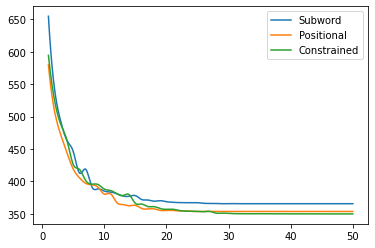

In [32]:
figure = plot_language_modeling_results(*language_models, subset='validation', kind='perplexity')

This is also nicely shown by the learning rate, which decreases the slowest for the RNN language model initialized with the position-independent word embeddings of the constrained positional model, indicating a greater capacity for learning:

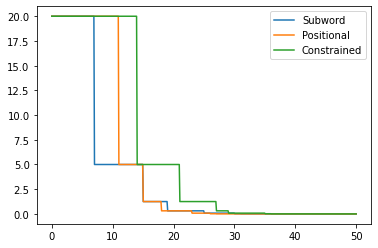

In [33]:
figure = plot_language_modeling_results(*language_models, subset='train', kind='learning_rate')

# Importance of Positions

So far, we have only looked at the applications of the *word* embeddings produced by our models. However, the embeddings of *positions* produced by the positional and constrained positional models are an interesting new object in and of themselves.

In this section, we will visualize the positional embeddings and we will discuss their properties and possible applications for transfer learning.

To inspect the general purpose of positional embeddings, we can plot their magnitude. This shows us that one of the basic functions of positional embeddings is the attenuation of distant context words:

In [34]:
from pine.qualitative_evaluation import plot_position_importance

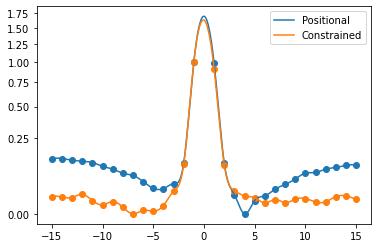

In [35]:
figure = plot_position_importance(positional_model, constrained_positional_model)

Interestingly, in the positional model, the importance of positions $p\not\in [-2; 2]$ increases with their distance from the masked word and even exceeds the importance of position $p=-2$ in the distant left context $p<-12$. In the constrained positional model, the importance of positions $p\not\in [-2; 2]$ is almost constant.

To explain this puzzling behavior, we will plot not the magnitude of the positional embeddings, but the absolute values of the actual *features of the positional embeddings*. To make it easier to see what is going on, we will split the features into different clusters to make it easier to see the different types of behavior they exhibit:

In [36]:
import matplotlib.pyplot as plt

plt.rcParams['image.cmap'] = 'tab10'

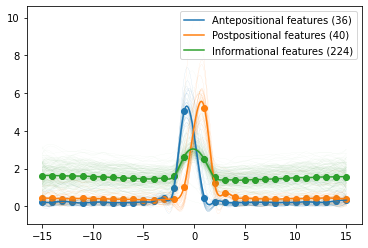

In [37]:
figure = positional_model.positional_feature_clusters.plot()

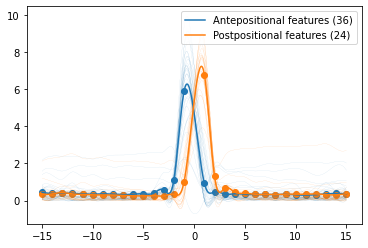

In [38]:
figure = constrained_positional_model.positional_feature_clusters.plot()

We can see that in the positional model, the features of positional vectors fall into three main clusters: The two smaller clusters, which we call *antepositional* and *postpositional*, and the bigger cluster, which is missing from the constrained positional model and which we call *informational*.

## Antepositional and Postpositional Features

The antepositional and postpositional features increase the importance of positions $p$ in anteposition ($-2, -1$) and in postposition ($1, 2$) of the masked word, respectively.

Context words most affected by antepositional features include “in”, “for”, and “coca”:

In [39]:
constrained_positional_model.classify_context_word('in')

'antepositional'

In [40]:
constrained_positional_model.classify_context_word('for')

'antepositional'

In [41]:
constrained_positional_model.classify_context_word('coca')

'antepositional'

Context words most affected by postpositional features include “ago”, “else”, and “cola”:

In [42]:
constrained_positional_model.classify_context_word('ago')

'postpositional'

In [43]:
constrained_positional_model.classify_context_word('else')

'postpositional'

In [44]:
constrained_positional_model.classify_context_word('cola')

'postpositional'

## Informational Features

The informational features increase the importance of positions $p\not\in [-2; 2]$. [Levy et al. (2014)][1] showed that context words with word embeddings of large magnitude have high self-information. I would appear that the purpose of informational features is to amplify distant self-informational context words that indicate the general topic of a sentence!

 [1]: https://proceedings.neurips.cc/paper/2014/file/feab05aa91085b7a8012516bc3533958-Paper.pdf

Context words most affected by informational features include “finance”, “sports”, and “politics”:

In [45]:
positional_model.classify_context_word('finance')

'informational'

In [46]:
positional_model.classify_context_word('sports')

'informational'

In [47]:
positional_model.classify_context_word('politics')

'informational'

In our constrained positional model, informational features are effectively replaced by ones, which is close to what the positional model has learnt.

## Conclusion

Our findings show that positional embeddings encode concepts that are highly interpretable and easy to grasp for us humans. In combination with word embeddings, positional embeddings can be used for the classification of words according to their function in sentences.